In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from tqdm import tqdm
import acd
from copy import deepcopy
import torchvision.utils as vutils
import models
from visualize import *
from data import *
sys.path.append('../trim')
from transforms_torch import transform_bandpass, tensor_t_augment, batch_fftshift2d, batch_ifftshift2d
from trim import *
from util import *
from attributions import *
from captum.attr import *
from functools import partial
import warnings
warnings.filterwarnings("ignore")
data_path = './cosmo'

# load dataset and model

In [2]:
# params
img_size = 256
class_num = 1

# cosmo dataset
transformer = transforms.Compose([ToTensor()])
mnu_dataset = MassMapsDataset(opj(data_path, 'cosmological_parameters.txt'),  
                              opj(data_path, 'z1_256'),
                              transform=transformer)

# dataloader
data_loader = torch.utils.data.DataLoader(mnu_dataset, batch_size=32, shuffle=False, num_workers=4)

# load model
model = models.load_model(model_name='resnet18', device=device, inplace=False, data_path=data_path).to(device)
model = model.eval()
# freeze layers
for param in model.parameters():
    param.requires_grad = False

optimize over mask 

In [3]:
# test im
X = iter(data_loader).next()['image'][0:1].to(device)
X.requires_grad = True

# output
with torch.no_grad():
    output = model(X).flatten()[1]

In [4]:
class Mask(nn.Module):
    def __init__(self, img_size=256):
        super(Mask, self).__init__()
        self.mask = nn.Parameter(torch.ones(img_size, img_size))
#         self.mask = nn.Parameter(torch.clamp(abs(torch.randn(img_size, img_size)), 0, 1))
        
    def forward(self, x):
        return torch.mul(self.mask, x)

In [5]:
# mask
mask = Mask().to(device)

# criterion
criterion = nn.MSELoss()

# l1-loss
l1loss = nn.L1Loss()

# Setup Adam optimizer
optimizer = optim.Adam(mask.parameters(), lr=0.05)

In [6]:
# Training Loop
# Lists to keep track of progress
losses = []
num_epochs = 1000

lamb_l1 = 5.0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    im_mask = mask(X)
    output_ = model(im_mask).flatten()[1] 
    # loss
    loss = -output_ + lamb_l1 * l1loss(mask.mask, torch.zeros_like(mask.mask))
    # zero grad
    optimizer.zero_grad()
    # backward
    loss.backward()
    # Update G
    optimizer.step()
    # projection
    mask.mask.data = torch.clamp(mask.mask.data, 0, 1)

    # Output training stats
    print('\rTrain Epoch: {}/{}'.format(epoch, num_epochs), end='')

    # Save Losses for plotting later
    losses.append(loss.item())


Starting Training Loop...
Train Epoch: 999/1000

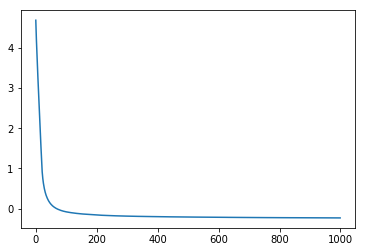

In [7]:
plt.plot(losses)
plt.show()

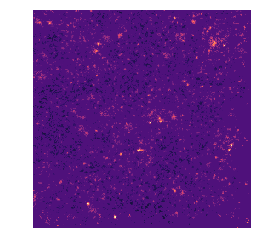

In [8]:
cshow(mask(X).data.cpu().squeeze())

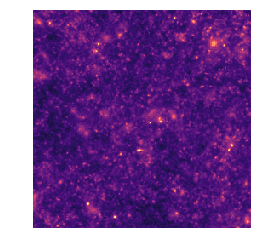

In [9]:
cshow(X.data.cpu().squeeze())